In [1]:
library(tidyverse)
library(clusterProfiler)
library(WGCNA)
library(parallel)
library(pheatmap)
library(RColorBrewer)
library(ggplotify)
library(grid)

# Custom package
library(rutils)

-- Attaching packages ---------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



clusterProfiler v3.18.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: 'clusterProfiler'


The following object is masked from 'package:purrr':

    simplify


The following object is masked from 'package:stats':

    filter


Loading required pa

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
project <- c("CESC", "UCS", "UCEC")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)

In [3]:
dset_idx <- 3

In [4]:
lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_data.RData"))
lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_network.RData"))

In [5]:
text_size <- 8
guide_size <- 1
family <- "ArialMT"
dpi <- 320
hm_ht <- 5
hm_wd <- 5

In [6]:
module_annot <- tibble(module_colors) %>%
    mutate(geneID = colnames(data_expr)) %>%
    column_to_rownames("geneID")

module_annot_colors <- list("module_colors" = unique(module_colors))
names(module_annot_colors[["module_colors"]]) <- unique(module_colors)

break_list <- seq(0, 0.4, by = 0.005)
pal <- colorRampPalette(rev(brewer.pal(n = 11, name = "RdYlBu")))(length(break_list))
# pal <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(length(break_list))

hm_breaks = c(0, 0.1, 0.2, 0.3, 0.4)
hm_labels = c("0", "0.1", "0.2", "0.3", "0.4")

In [7]:
tom_hm <- tom - diag(1, nrow(tom), nrow(tom))
rownames(tom_hm) <- colnames(data_expr)
colnames(tom_hm) <- colnames(data_expr)

In [14]:
rowSums(tom_hm) %>% quantile()

0%        25%        50%        75%       100% 
 0.3000765  1.7082870  2.6340958  4.4939226 26.5164136

Saving 6.67 x 6.67 in image



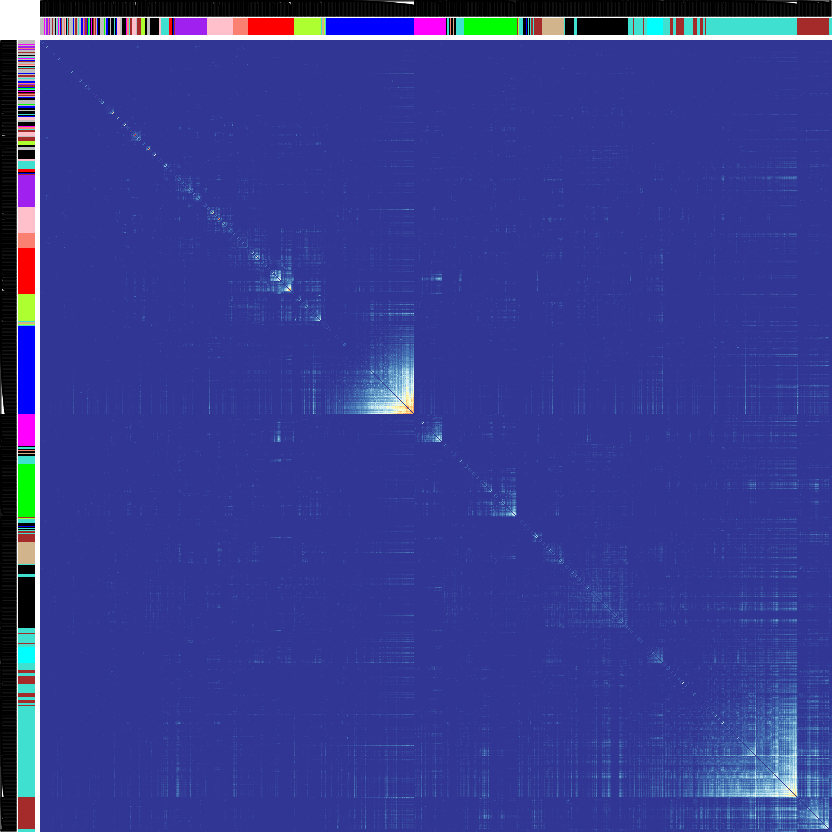

In [8]:
hm <- pheatmap(
    tom_hm,
    cluster_rows = gene_tree,
    cluster_cols = gene_tree,
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_row = module_annot,
    annotation_names_row = FALSE,
    annotation_col = module_annot,
    annotation_colors = module_annot_colors,
    annotation_names_col = FALSE,
    annotation_legend = FALSE,
    legend = FALSE,
    color = pal,
    breaks = break_list,
    legend_breaks = hm_breaks,
    legend_labels = hm_labels,
    treeheight_row = 5,
    treeheight_col = 5
)
hm$gtable$grobs[[1]]$gp <- gpar(lwd = 0.25)
hm$gtable$grobs[[2]]$gp <- gpar(lwd = 0.25)
# hm
hm <- as.ggplot(hm)
ggsave(paste0(dirs$figures_dir, "/network/", unified_dsets[dset_idx], "_TOM_heatmap.png"), hm, dpi = dpi)


In [9]:
max(tom_hm)

[1] 0.3421612

In [10]:
tom_df <- tom_hm %>%
    as_tibble(rownames = "geneID") %>%
    pivot_longer(2:ncol(.), names_to = "incident_geneID", values_to = "tom")

In [11]:
tom_tileplot <- ggplot(data = tom_df) +
    geom_tile(aes(x = incident_geneID, y = geneID, fill = tom)) +
    scale_fill_gradientn(colors = pal, limits = c(0.0, .385), labels = hm_labels, name = "TOM") +
    theme(text = element_text(size = text_size))

In [12]:
assign(paste0(project[dset_idx], "_tomplot"), hm)
assign(paste0(project[dset_idx], "_tom_tileplot"), tom_tileplot)
save(
    list = c(paste0(project[dset_idx], "_tomplot"), paste0(project[dset_idx], "_tom_tileplot")),
    file = paste0(dirs$figures_dir, "/saved_obj/", unified_dsets[dset_idx], "_tomplots.RData")
)